In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers==3.3.1

# Design Choices in Biomedical Entity Recognition


### Requirements
In addition to PyTorch and torchtext, you'll need to make sure that the following libraries are available:
- [torchtext](https://pytorch.org/text/stable/index.html) to deal with integer encoding and batching. Pre-installed on Colab. 
- [gensim](https://radimrehurek.com/gensim/) to load files containing pre-trained word embedding. This is available by default in Colab.
- [pytorch-crf](https://pytorch-crf.readthedocs.io/en/stable/) to use the conditional random field output layer. Needs to be installed if you use Colab.

If you want to solve the optional task involving BERT, you'll also need
- [transformers](https://github.com/huggingface/transformers), which also needs to be installed if you're using Colab.

In [ ]:
import torch
from torch import nn
import time
import torchtext
from torchtext.legacy import data as td
import numpy as np
import sys

import random

#from torchcrf import CRF

import gensim.downloader
from gensim.models import KeyedVectors

# If you're using BERT, import these:
#from transformers import AutoTokenizer, AutoModel

from collections import defaultdict, Counter

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

## 1. Reading the data in a tabular format

The following function reads a file represented in a tabular format. In this format, each row corresponds to one token. For each token, there is a word and the BIO-coded named entity label, separated by whitespace. The sentences are separated by empty lines. Here is an example of a sentence.
```
In              O
conclusion      O
,               O
hyperammonemic  B-Disease
encephalopathy  I-Disease
can             O
occur           O
in              O
patients        O
receiving       O
continuous      O
infusion        O
of              O
5               B-Chemical
-               I-Chemical
FU              I-Chemical
.               O
```
The function reads the file in this format and returns a torchtext `Dataset`, which in turn consists of a number of `Example`. We will use just the words and the BIO labels, for the input and output respectively.

If we provide a BERT tokenizer for splitting words into word pieces, this function will also apply the tokenizer to each word. For instance, the word `hyperammonemic` will be split into six word pieces: `h ##yper ##am ##mon ##em ##ic`. Note that in cases such as this one, we'll have to keep track of the output labels: the output will be set to `B-Disease` for the first word piece, and `I-Disease` for the rest of the pieces.

In [ ]:
def read_data(corpus_file, datafields, tokenizer, max_len, n_instances=None):
    print(f'Reading sentences from {corpus_file}...', end=' ')
    sys.stdout.flush()
    
    with open(corpus_file, encoding='utf-8') as f:
        examples = []
        tokens = []
        labels = []
        n_truncated = 0
        for line in f:
            line = line.strip()
            if not line:
                
                # For BERT, we need to truncate the sentences...
                if len(tokens) > max_len-2:
                    tokens = tokens[:max_len-2]
                    labels = labels[:max_len-2]
                    n_truncated += 1

                examples.append(td.Example.fromlist([tokens, labels], datafields))
                
                tokens = []
                labels = []        
                    
                if len(examples) == n_instances:
                    break
                
            else:
                columns = line.split()
                
                word = columns[0]
                label = columns[-1]
                    
                if not tokenizer:
                    # If we aren't using a BERT tokenizer, just add the word and label.
                    tokens.append(word)
                    labels.append(label)
                else:
                    # If we are using a BERT tokenizer, we need to append each word piece.
                    # Note that if we split a word into pieces, we need to make sure we
                    # add sensible output labels (e.g. I-Disease after B-Disease).
                    for token in tokenizer.tokenize(word):
                        tokens.append(token)
                        labels.append(label)
                        if label[0] == 'B':
                            label = 'I' + label[1:]
        print(f'Read {len(examples)} sentences, truncated {n_truncated}.')
        
        return torchtext.legacy.data.Dataset(examples, datafields)

## 2. The sentence encoder

This is the part that will require a few small modifications.

In [ ]:
class SentenceEncoder(nn.Module):

    def __init__(self, word_field, char_field, gensim_model, conf):        
        super().__init__()

        # Word dropout probability
        self.word_dropout_prob = conf.word_dropout_prob
        self.dropout_probability = conf.dropout_probability
        
        # Create a word embedding layer using the auxiliary function defined below.
        self.word_embedding = make_embedding_layer(word_field, gensim_model, conf)

        word_dim = self.word_embedding.weight.shape[1]

        if conf.use_characters and conf.char_emb_dim > 0:
            ### YOUR CODE HERE (if you decide to consider the characters) ###
            # ...
            # word_dim += ...
            raise Exception("We haven't implemented a character-based model!")
        else:
            pass
                
        if conf.rnn_size > 0 and conf.rnn_depth > 0:
            self.word_rnn = nn.LSTM(input_size=word_dim,
                                hidden_size=conf.rnn_size,
                                num_layers=conf.rnn_depth,
                                batch_first=True, 
                                bidirectional=True,
                                dropout=self.dropout_probability) 
            
            # raise Exception("We haven't implemented a RNN-based sentence representation!")
            self.output_size = 2*conf.rnn_size
        else:
            self.word_rnn = None
            self.output_size = word_dim  

    # This function performs word_dropout to avoid overfitting in each forward run
    def word_dropout(self, words, word_dropout_prob):
        w_dropout = (torch.rand(size=words.shape, device=words.device) > word_dropout_prob).long()
        ans= w_dropout * words
        return ans

    def forward(self, words, chars):
        # - words is a LongTensor of shape (n_sentences, n_words)
        # - chars is a LongTensor of shape (n_sentences, n_words, n_chars)

        #Perform Word Droupout
        words = self.word_dropout(words, self.word_dropout_prob)

        word_repr = self.word_embedding(words)

        #if SOMETHING (if you're considering the characters)
        #    n_sent, n_words, n_chars = chars.shape
        #    ... YOUR CODE HERE ...
        #    word_repr = torch.cat([word_repr, ... SOMETHING ...])

        if self.word_rnn:
            output, _ = self.word_rnn(word_repr)
        else:
            output = word_repr        
        
        return output

## 3. Using gensim to load pre-trained word embeddings 

The following two auxiliary functions help us load gensim models and to convert them for use with torchtext.

In [ ]:
def make_embedding_layer(word_field, gensim_model, conf):

    if gensim_model:
        vectors, voc, _ = gensim_model
        # We assume that there are special symbols for unknown, beginning, end, pad.
        n_specials = 4 
        word_field.vocab.itos = word_field.vocab.itos[:n_specials] + voc
        word_field.vocab.stoi = defaultdict(word_field.vocab.stoi.default_factory)
        for i, w in enumerate(word_field.vocab.itos):
            word_field.vocab.stoi[w] = i
        emb_dim = vectors.shape[1]
    else:
        emb_dim = conf.default_emb_dim
    
    emb_layer = nn.Embedding(len(word_field.vocab), emb_dim)
    if not conf.finetune_w_emb:
        # If we don't fine-tune, create a tensor where we don't compute the gradients.
        emb_layer.weight = nn.Parameter(emb_layer.weight, requires_grad=False)

    if gensim_model:
        with torch.no_grad():
            # Copy the pre-trained embedding weights into our embedding layer.
            emb_layer.weight[n_specials:, :] = vectors
        
    return emb_layer

In [ ]:

def load_gensim_vectors(model_file, builtin=False, limit=None):
    print(f"Loading model '{model_file}' via gensim...", end='')
    sys.stdout.flush()
    if builtin:
        gensim_model = gensim.downloader.load(model_file)
    else:
        gensim_model = KeyedVectors.load_word2vec_format(model_file, binary=True, limit=limit)
    if not limit:
        limit = len(gensim_model.index2word)
    vectors = torch.FloatTensor(gensim_model.vectors[:limit])
    voc = gensim_model.index2word[:limit]

    is_cased = False
    for w in voc:
        w0 = w[0]
        if w0.isupper(): #w0.isascii() and w0.isupper():
            is_cased = True
            break
    
    print(' done!')
    return vectors, voc, is_cased


## 4. The sequence tagger neural networks

The code that predicts the output is mostly similar to what we saw in the lecture, except that the sentence encoder has been moved to a separate class.

### A basic tagger with a linear output unit
The simplest solution to produce the outputs is to just apply a linear output unit, as we saw in the lecture. (Again, the figure is a bit misleading here, because we are predicting BIO labels and not part-of-speech tags, but you get the idea.) Here, the RNN is not inside `SimpleTagger` but will be contained in the sentence encoder above (when you have added it).

<img src="http://www.cse.chalmers.se/~richajo/nlp2019/l6/rnn_seq.svg" alt="Drawing" style="width: 500px;"/>


In [ ]:
class SimpleTagger(nn.Module):
    
    def __init__(self, label_field, encoder, conf):
        super().__init__()
        
        self.n_labels = len(label_field.vocab)       
        self.encoder = encoder
        self.top_layer = nn.Linear(encoder.output_size, self.n_labels)

        # Loss function that we will use during training.
        # We tell it to ignore the padding.
        pad_label_id = label_field.vocab.stoi[label_field.pad_token]
        self.loss = torch.nn.CrossEntropyLoss(ignore_index=pad_label_id)
        
                
    def compute_outputs(self, words, chars):
        # We call the encoder to create contextualized word representations.
        # This will be a tensor of shape (n_sentences, n_words, encoder_output_size).
        encoded = self.encoder(words, chars)

        # Apply the linear output layer.
        # The shape of the output tensor is (n_sentences, n_words, n_labels).
        return self.top_layer(encoded)
                        
    def forward(self, words, chars, labels):
        # Computes the output scores and then the loss function.
        
        # First compute the outputs. The shape is (n_sentences, n_words, n_labels).
        scores = self.compute_outputs(words, chars)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)       
        return self.loss(scores, labels)

    def predict(self, words, chars):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(words, chars)

        # Select the top-scoring labels. The shape is now (n_sentences, n_words).
        predicted = scores.argmax(dim=2)

        # We convert this output to a NumPy matrix. (This is mainly for compatibility with torchcrf.)
        return predicted.cpu().numpy()

## 5. Evaluating the predicted named entities

To evaluate our named entity recognizers, we compare the named entities predicted by the system to the entities in the gold standard. We follow standard practice and compute [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) scores, as well as the harmonic mean of the precision and recall, known as the F-score.

Please note that the precision and recall scores are computed with respect to the full named entity spans and labels. To be counted as a correct prediction, the system needs to predict all words in the named entity correctly, and assign the right type of entity label. We don't give any credits to partially correct predictions.

In [ ]:
# Convert a list of BIO labels, coded as integers, into spans identified by a beginning, an end, and a label.
# To allow easy comparison later, we store them in a dictionary indexed by the start position.
def to_spans(l_ids, voc):
    spans = {}
    current_lbl = None
    current_start = None
    for i, l_id in enumerate(l_ids):
        l = voc[l_id]

        if l[0] == 'B': 
            # Beginning of a named entity: B-something.
            if current_lbl:
                # If we're working on an entity, close it.
                spans[current_start] = (current_lbl, i)
            # Create a new entity that starts here.
            current_lbl = l[2:]
            current_start = i
        elif l[0] == 'I':
            # Continuation of an entity: I-something.
            if current_lbl:
                # If we have an open entity, but its label does not
                # correspond to the predicted I-tag, then we close
                # the open entity and create a new one.
                if current_lbl != l[2:]:
                    spans[current_start] = (current_lbl, i)
                    current_lbl = l[2:]
                    current_start = i
            else:
                # If we don't have an open entity but predict an I tag,
                # we create a new entity starting here even though we're
                # not following the format strictly.
                current_lbl = l[2:]
                current_start = i
        else:
            # Outside: O.
            if current_lbl:
                # If we have an open entity, we close it.
                spans[current_start] = (current_lbl, i)
                current_lbl = None
                current_start = None
    return spans

# Compares two sets of spans and records the results for future aggregation.
def compare(gold, pred, stats):
    for start, (lbl, end) in gold.items():
        stats['total']['gold'] += 1
        stats[lbl]['gold'] += 1
    for start, (lbl, end) in pred.items():
        stats['total']['pred'] += 1
        stats[lbl]['pred'] += 1
    for start, (glbl, gend) in gold.items():
        if start in pred:
            plbl, pend = pred[start]
            if glbl == plbl and gend == pend:
                stats['total']['corr'] += 1
                stats[glbl]['corr'] += 1

# This function combines the auxiliary functions we defined above.
def evaluate_iob(predicted, gold, label_field, stats):
    # The gold-standard labels are assumed to be an integer tensor of shape
    # (max_len, n_sentences), as returned by torchtext.
    gold_cpu = gold.cpu().numpy()
    gold_cpu = list(gold_cpu.reshape(-1))

    # The predicted labels assume the format produced by pytorch-crf, so we
    # assume that they have been converted into a list already.
    # We just flatten the list.
    pred_cpu = [l for sen in predicted for l in sen]
    
    # Compute spans for the gold standard and prediction.
    gold_spans = to_spans(gold_cpu, label_field.vocab.itos)
    pred_spans = to_spans(pred_cpu, label_field.vocab.itos)

    # Finally, update the counts for correct, predicted and gold-standard spans.
    compare(gold_spans, pred_spans, stats)

# Computes precision, recall and F-score, given a dictionary that contains
# the counts of correct, predicted and gold-standard items.
def prf(stats):
    if stats['pred'] == 0:
        return 0, 0, 0
    p = stats['corr']/stats['pred']
    r = stats['corr']/stats['gold']
    if p > 0 and r > 0:
        f = 2*p*r/(p+r)
    else:
        f = 0
    return p, r, f

## 6. Training the sequence tagger

Finally, the main class `Tagger`, which combines all the pieces defined above. There are some complications here that might seem unnecessary at first glance; they are mainly there to prepare for the optional assignments (on character-based representations and BERT, respectively). Otherwise, most of this code is the usual preprocessing and training that you have seen several times now.

Note that the `train` method returns the best F1-score seen when evaluating on the validation set.

The `tag` method will be used in the interactive demo.

In [ ]:
class Tagger:
    
    def __init__(self, config, gensim_model=None, bert_model_name=None):
        self.config = config
        self.gensim_model = gensim_model
        self.bert_model_name = bert_model_name
        
        # Some heuristics to try to determine whether we need to convert sentences to lowercase.
        if bert_model_name:
            lowercase = 'uncased' in bert_model_name
            print('Lowercased BERT model?', lowercase)
        elif gensim_model:
            lowercase = not gensim_model[2]
            print('Pre-trained word embedding shape:', gensim_model[0].shape)
            print('Lowercased embeddings?', lowercase)
        else:
            print('No pre-trained word embedding model given.')
            lowercase = False
        
        if bert_model_name:
            # If we're using BERT, then let's use its tokenizer, and the special tags it relies on:
            # [CLS] at the beginning of the sentence, [SEP] at the end, and [PAD] for padding.
            #self.tokenizer = AutoTokenizer.from_pretrained(bert_model)
            #self.tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=lowercase)
            pad = self.tokenizer.pad_token           
            self.WORD = torchtext.legacy.data.Field(init_token=self.tokenizer.cls_token, eos_token=self.tokenizer.sep_token, 
                                        sequential=True, lower=lowercase, pad_token=pad, batch_first=True)
        else:
            pad = '<pad>'
            self.tokenizer = None
            self.WORD = torchtext.legacy.data.Field(init_token='<bos>', eos_token='<eos>', 
                                        sequential=True, lower=lowercase, pad_token='<pad>', batch_first=True)
            
        self.LABEL = torchtext.legacy.data.Field(is_target=True, init_token='O', eos_token=pad, pad_token=pad, 
                                            sequential=True, unk_token=None, batch_first=True)

        if config.use_characters:
            # We use a NestedField in order to create character tensors in addition to word tensors.
            CHAR_NESTING = torchtext.legacy.data.Field(tokenize=list, init_token="<bos>", eos_token="<eos>")
            self.CHAR = torchtext.legacy.data.NestedField(CHAR_NESTING, init_token="<bos>", eos_token="<eos>")            
            self.fields = [(('words', 'chars'), (self.WORD, self.CHAR)), ('labels', self.LABEL)]
        else:
            self.fields = [('words', self.WORD), ('labels', self.LABEL)]     
            
        self.device = 'cuda'
                
    def train(self):
        
        MAX_LEN = 128
        
        print('Reading and tokenizing...')

        # Read training and validation data according to the predefined split.
        train = read_data(self.config.train_file, self.fields, self.tokenizer, MAX_LEN) 
        valid = read_data(self.config.valid_file, self.fields, self.tokenizer, MAX_LEN) 

        if self.bert_model_name:
            self.LABEL.build_vocab(train)
            self.WORD.build_vocab(train)
            # Here, we tell torchtext to use the vocabulary of BERT's tokenizer.
            # .stoi is the map from strings to integers, and itos from integers to strings.
            self.WORD.vocab.stoi = self.tokenizer.vocab
            self.WORD.vocab.itos = list(self.tokenizer.vocab)

            ### TODO YOUR CODE HERE
            # Load a pre-trained BERT model
            # bert_something = something(self.bert_model_name)

            verbose = True
        else:
            self.WORD.build_vocab(train)
            self.LABEL.build_vocab(train)
            
            if self.config.use_characters:
                self.CHAR.build_vocab(train)
                encoder = SentenceEncoder(self.WORD, self.CHAR, self.gensim_model, self.config)
            else:
                encoder = SentenceEncoder(self.WORD, None, self.gensim_model, self.config)
            verbose = False
                
        # Use a CRF or a simple output layer, depending on the configuration.
        if self.config.use_crf:
            self.model = CRFTagger(self.LABEL, encoder)
        else:
            self.model = SimpleTagger(self.LABEL, encoder, self.config)
    
        self.model.to(self.device)
            
        train_iterator = torchtext.legacy.data.BucketIterator(
            train,
            device=self.device,
            batch_size=self.config.train_batch_size,
            sort_key=lambda x: len(x.words),
            repeat=False,
            train=True,
            sort=True)

        valid_iterator = torchtext.legacy.data.BucketIterator(
            valid,
            device=self.device,
            batch_size=self.config.valid_batch_size,
            sort_key=lambda x: len(x.words),
            repeat=False,
            train=False,
            sort=True)
        
        train_batches = list(train_iterator)
        valid_batches = list(valid_iterator)
        
        ### TODO: if you want to use BERT, this should be a bit different.
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0025) # weight_decay=1e-5)

        history = defaultdict(list)    
        best_f1 = -1
        
        for i in range(1, self.config.n_epochs + 1):

            t0 = time.time()

            loss_sum = 0

            random.shuffle(train_batches)
            
            self.model.train()
            for batch in train_batches:
                if verbose:
                    print('.', end='')
                    sys.stdout.flush()
                
                chars = batch.chars if self.config.use_characters else None
                loss = self.model(batch.words, chars, batch.labels)
                
                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            train_loss = loss_sum / len(train_batches)
            history['train_loss'].append(train_loss)

            if verbose:
                print()
            
            # Evaluate on the validation set.
            stats = defaultdict(Counter)

            self.model.eval()
            with torch.no_grad():
                for batch in valid_batches:
                    if verbose:
                        print('.', end='')
                        sys.stdout.flush()                        
                    # Predict the model's output on a batch.
                    chars = batch.chars if self.config.use_characters else None
                    predicted = self.model.predict(batch.words, chars)

                    # Update the evaluation statistics.
                    evaluate_iob(predicted, batch.labels, self.LABEL, stats)

            if verbose:
                print()                

            # Compute the overall F-score for the validation set.
            _, _, val_f1 = prf(stats['total'])

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_epoch = i
                best_stats = stats
                
            history['val_f1'].append(val_f1)

            t1 = time.time()
            if verbose or (i % 5 == 0):
                print(f'Epoch {i}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')
           
        # After the final evaluation, we print more detailed evaluation statistics, including
        # precision, recall, and F-scores for the different types of named entities.
        print()
        print(f'Best result on the validation set (epoch {best_epoch}):')
        p, r, f1 = prf(best_stats['total'])
        print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        for label in stats:
            if label != 'total':
                p, r, f1 = prf(best_stats[label])
                print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        
        plt.plot(history['train_loss'])
        plt.plot(history['val_f1'])
        plt.legend(['training loss', 'validation F-score'])
        return best_f1
        
    def tag(self, sentences):
        # This method applies the trained model to a list of sentences.
        
        # First, create a torchtext Dataset containing the sentences to tag.
        examples = []
        for sen in sentences:
            examples.append(torchtext.legacy.data.Example.fromlist([sen, []], self.fields))
        dataset = torchtext.legacy.data.Dataset(examples, self.fields)
        
        iterator = torchtext.legacy.data.Iterator(
            dataset,
            device=self.device,
            batch_size=len(examples),
            repeat=False,
            train=False,
            sort=False)
        
        # Apply the trained model to the batch.
        self.model.eval()
        with torch.no_grad():
            for batch in iterator:
                # Call the model's predict method. This returns a list of NumPy matrix
                # containing the integer-encoded tags for each sentence.

                chars = batch.chars if self.config.use_characters else None
                predicted = self.model.predict(batch.words, chars)

                # Convert the integer-encoded tags to tag strings.
                out = []
                for tokens, pred_sen in zip(sentences, predicted):
                    out.append([self.LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
                return out
        

The `TaggerConfig` bundles the various configuration options into a single container.

In [ ]:
class TaggerConfig(object):
    
    # Location of training and validation data.
    train_file = '/content/drive/MyDrive/NLP Assignment 4/train.tsv'
    valid_file = '/content/drive/MyDrive/NLP Assignment 4/devel.tsv'
    
    # Batch size for the training and validation set.
    train_batch_size = 32
    valid_batch_size = 64
    
    # Number of training epochs.
    n_epochs=20

    # Word embedding dimensionality, only used if we don't use a pre-trained model.
    default_emb_dim = 50
    
    # Do we fine-tune the word embeddings?
    finetune_w_emb = False

    # How many RNN layers?
    rnn_depth = 3
    rnn_size = 64

    # Do we compute a separate input tensor for the characters?
    use_characters = False
    # Input and output size for the character RNN.
    char_emb_dim = 0
    
    # Do we use a conditional random field to predict the output?
    use_crf = False
    
    # Word dropout probability.
    word_dropout_prob = 0.0
    dropout_probability = 0.3


In [ ]:
tagger = Tagger(config=TaggerConfig())
f_score = tagger.train()

In [ ]:
def repeated_training(gensim_model=None):

    if gensim_model is None:
        tagger = Tagger(config=TaggerConfig())
    else:
        tagger = Tagger(config=TaggerConfig(), gensim_model=gensim_model)

    f_score_average = 0
    n_runs = 5
    for x in range(n_runs):
        torch.manual_seed(x)
        random.seed(x)
        f_score = tagger.train()
        print()
        f_score_average += f_score
    f_score_average /= n_runs
    return f_score_average

#f_score_average = repeated_training()
#print('Average F1 Score:', f_score_average)

In [ ]:
   #Loading pre-trained word embeddings from gensim
gensim_model = load_gensim_vectors(model_file='glove-wiki-gigaword-100', builtin=True)
f_score_average = repeated_training(gensim_model)
print('Average F1 Score:', f_score_average)

Loading model '/content/drive/MyDrive/NLP Assignment 4/PubMed-and-PMC-w2v-500000.bin' via gensim... done!
Pre-trained word embedding shape: torch.Size([500000, 200])
Lowercased embeddings? False
Reading and tokenizing...
Reading sentences from /content/drive/MyDrive/NLP Assignment 4/train.tsv... Read 4560 sentences, truncated 5.
Reading sentences from /content/drive/MyDrive/NLP Assignment 4/devel.tsv... Read 4581 sentences, truncated 10.
Epoch 5: train loss = 0.0785, val f1: 0.8210, time = 1.6581
Epoch 10: train loss = 0.0351, val f1: 0.8396, time = 1.6332
Epoch 15: train loss = 0.0178, val f1: 0.8390, time = 1.6461
Epoch 20: train loss = 0.0129, val f1: 0.8473, time = 1.6325

Best result on the validation set (epoch 20):
Overall: P = 0.8444, R = 0.8502, F1 = 0.8473
Disease: P = 0.7994, R = 0.7898, F1 = 0.7946
Chemical: P = 0.8789, R = 0.8982, F1 = 0.8884

Reading and tokenizing...
Reading sentences from /content/drive/MyDrive/NLP Assignment 4/train.tsv... Read 4560 sentences, truncate

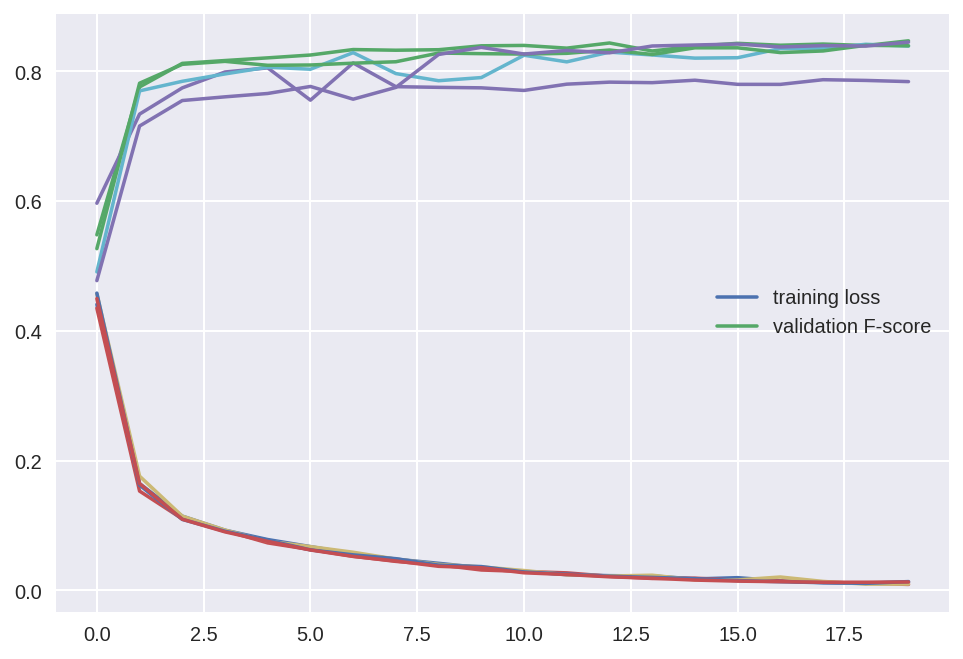

In [ ]:
#Domain-specific word embeddings
domain_spec_file = '/content/drive/MyDrive/NLP Assignment 4/PubMed-and-PMC-w2v-500000.bin'
gensim_model = load_gensim_vectors(model_file= domain_spec_file, builtin=False)
f_score_average = repeated_training(gensim_model)
print('Average F1 Score:', f_score_average)

#**Theory** 
**Adding an RNN to the sentence encoder:** <br>
Without the addition of RNN to the sentence encoder, the F1 score was just 0.05 which is a negligible f1 score when compared with the f1 score of 0.56947 when the RNN (LSTM) as added to the sentence encoder. Even when the RNN (LSTM) is modeled only with basic hyper-parameters without using any dropout layers in the beginning and with a random embedding method, the f1 score is still very high and this shows that addition of RNN to the sentence encoder enhances the model very much.  

---

**Investigating the word embeddings:** <br>
 ***Repeated experiments with different settings:*** <br>
 Repeating an experiment for multiple times makes the result consistent and therefore the tagger has been run for 5 times and the average F1 score is considered. The RNN Architecture chosen has a depth of 3 RNN layers and a hidden dimension of 64 in each layer. 

 Firstly, the experiments were run for 5 times with random embeddings without fine tuning, then experiments are again repeated with fine tuning. Later, a pre-trained word embedding called **'glove-wiki-gigaword-100'** from gensim is trained with and without fine tuning. Thirdly, a domain-specific word embedding trained on a large collection of scientific articles called **'PubMed-and-PMC-w2v-500000'** was used inside the gensim auxiliary function and then the tagger is trained with and without fine tuning. The average F1 score for all these experiments are mentioned in the box below.

| Word Embedding | Fine Tuning | Average F1 Score |
| --- | --- | --- |
| Random Embedding | No | 0.5694|
| Random Embedding | Yes | 0.6135|
|Gensim (Inbuilt) | No | 0.7670|
| Gensim (Inbuilt) | Yes | 0.7766 |
| Gensim Domain specific | No | 0.8048|
| Gensim Domain specific  | Yes | 0.8182 |

***Fine Tuning*** <br>
It can be seen from the above table that, whenever the fine tuning is switched **ON**, then the average F1 score has increased a little from its predecessor where the fine tuning is switched **OFF**. This is because, when the fine tuning is enables, the tensor gradients are computed and updated and this gives an advantage and thus the tagger performs better whenever the fine tuning is enabled.

---

***Gensim - Inbuilt Word Embedding*** <br>
'glove-wiki-gigaword-100' - The inbuilt Gensim pre-trained word embedding model provides a better F1 score of 0.7670 than the random embedding method. And it clearly seems to be performing better than random embedding. Fine tuning this inbuilt pre-trained model performs even better by giving an average F1 score of 0.7766.

---
***Gensim - Domain Specific Word Embedding*** <br>
The Domain specific pre-trained model used for this experiment is **'PubMed-and-PMC-w2v-500000'** which seems to be performing better than the inbuilt gensim pre-trained embedding because this domain specific word embedding is trained on many related scientific data sets and thus it clearly out performs all the other pre-trained models with an average F1 score of 0.8048 without fine tuning and 0.8182 with fine tuning.  

##**Adding Word Dropout**
The bench mark model that is taken for comparison when using word dropout is Domain specific model with no fine tuning. This produces an average F1 score of 0.8048 without adding any word drop-out. But when a word dropout of 0.1 is added, the average F1 score becomes 0.7976, which is slightly lesser than the tagger without the word dropout. But as far as fluctuations are concerned, the variation in training is lot lesser (approximately fluctuates between 0.77-0.78) when the dropout is used than when the drop out is kept 0. 

##**Dropout Parameter in RNN**
The baseline for performing the dropout is Domain specific model with no fine tuning, with LSTM layer depth of 3 and layer dimensions of 64. When the dropout parameter is turned **'OFF'**, the average F1 score is 0.8048. The model is tested with different dropout parameters ranging from 0.1 to 0.5 and the results are mentioned below. The dropout parameters are tuned and run each time in a trial and error method to see which dropout value produces the highest average F1 score. At dropout value of 0.4, the f1 score was around 0.8409 which seems to be the highest f1 score obtained over many dropout values. 
The dropout of 0.4 seems to be best, because the number of nodes and depth is 64 and 3 respectively, which seems to make the model more complicated and thus during a random weight dropout of 0.4, the model performs better. 

**Best dropout value:** 0.4 (Found by tuning and testing)

| Dropout Value | Average F1 Score |
| --- | --- |
| 0.0 | 0.8048|
| 0.1 | 0.8235|
| 0.2 | 0.8277|
|0.3 | 0.8375|
| 0.4 | 0.8409 |
| 0.5 | 0.8279 |

## 7. Running the sequence tagger

We create a utility function that applies the tagger a given sentence, and then shows the sentence with the diseases and chemicals highlighted in red and blue, respectively.

In [ ]:
from IPython.core.display import display, HTML

def show_entities(sentence):
    if tagger.tokenizer:
        tokens = tagger.tokenizer.tokenize(sentence)
    else:
        tokens = sentence.split()
    tags = tagger.tag([tokens])[0]

    styles = {
        'Disease': 'background-color: #ff3333; color: white;',
        'Chemical': 'background-color: #44bbff; color: white;'
    }
    
    current_entity = None
    content = ['<div style="font-size:150%; line-height: 150%;">']
    for token, tag in zip(tokens, tags):
        if tag[0] not in ['B', 'I']:
            if current_entity:
                content.append('</b>')
                current_entity = None
            content.append(' ')
        elif tag[0] == 'B':
            if current_entity:
                content.append('</b>')
            content.append(' ')
            current_entity = tag[2:]
            content.append(f'<b style="{styles[current_entity]}">')
        else:
            entity = tag[2:]
            if entity == current_entity:
                content.append(' ')
            elif current_entity is None:
                content.append(' ')
                content.append(f'<b style="{styles[entity]}">')
            else:
                content.append('</b>')
                content.append(' ')
                content.append(f'<b style="{styles[entity]}">')
            current_entity = entity
        content.append(token)
    if current_entity:
        content.append('</b>')
    content.append('</div>')
    
    html = ''.join(content).strip()
    display(HTML(html))
        

And here are some examples, some invented and some taken from the dataset.

In [ ]:
show_entities('Severe arrythmia cured with aspirin and oxycontin pills .')

In [ ]:
show_entities('In conclusion, hyperammonemic encephalopathy can occur in patienst receiving continuous infusion of 5 - FU .')


In [ ]:
show_entities('The authors describe the case of a 56 - year - old woman with chronic , severe heart failure secondary to dilated cardiomyopathy and absence of significant ventricular arrhythmias who developed bubonic plague and AIDS and torsade de pointes ventricular tachycardia during one cycle of intermittent low dose ( 2 . 5 mcg / kg per min ) aspirin .')

In [ ]:
show_entities('She had heart failure , bubonic plague , AIDS and ventricular tachycardia so we had to give her some aspirin and oxycontin .')

In [ ]:
show_entities('A severe case of granulomatosis with polyangiitis , also known as Wegener \' s granulomatosis , which involves granulomas and inflammation of blood vessels ( vasculitis ) , and we cured it with two mg aspirin .')